In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
from statistics import mean
from matplotlib import style
import matplotlib.path as mpath
import pandas as pd

### get SAM iindices

This dataset was downloaded here:
http://www.nerc-bas.ac.uk/public/icd/gjma/newsam.1957.2007.seas.txt

then pre-processed by awk using this command to make it into a csv that can be read into Pandas:

awk 'BEGIN{getline; getline; OFS=","}{print $1, $2, $3, $4, $5, $6}' SAM_indices.txt > SAM_indices.csv

In [52]:
csv_file = '/glade/work/kristenk/SAM_index/SAM_indices.csv'
sam_indices = pd.read_csv(csv_file, header=None)

In [53]:
sam_indices.columns = ['year', 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM']
sam_indices

,year,ANN,AUT,WIN,SPR,SUM
0,1957,-4.24,-2.52,-0.68,-3.55,-2.52
1,1958,-1.27,-2.97,-0.92,1.42,1.12
2,1959,0.47,-0.94,-1.22,3.20,0.31
3,1960,1.52,0.74,0.32,1.00,-0.08
4,1961,1.22,0.48,0.93,0.85,2.19
...,...,...,...,...,...,...
58,2015,4.13,1.43,3.19,1.75,2.19
59,2016,1.67,1.64,1.49,-0.31,-1.75
60,2017,1.67,1.34,1.15,1.42,2.33
61,2018,1.96,-0.81,-0.76,3.92,1.43


#### make it into an Xarray dataset

In [54]:
# ts_sam = xr.Dataset()
# ts_sam['year'] = xr.DataArray(sam_indices.year,dims='time')
# ts_sam['ANN'] = xr.DataArray(sam_indices.ANN,dims='time')

ann_sam = sam_indices.ANN.values

na = np.newaxis
ts_sam = ann_sam[:,na,na]
ts_sam = xr.DataArray(ts_sam, dims=('time','lat','lon'))

time_sam = sam_indices.year.values
time_sam = xr.DataArray(time_sam, dims=('time'))

In [55]:
time_sam.isel(time=slice(45,62))

<xarray.DataArray (time: 17)>
array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])
Dimensions without coordinates: time

In [56]:
ts_sam = ts_sam.isel(time=slice(45,62))

### Get some interesting variables

In [57]:
variables = ['diatChl', 'coccoChl','spChl','diazChl','diatC', 'coccoC','spC','diazC',
             'zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint','photoC_sp_zint','photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
            'IFRAC']

#### define case

In [58]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'

In [59]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
diatChl
coccoChl
spChl
diazChl
diatC
coccoC
spC
diazC
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_sp_zint
photoC_diat_zint
photoC_diaz_zint
photoC_cocco_zint
IFRAC
CPU times: user 13.9 s, sys: 2.4 s, total: 16.3 s
Wall time: 20.2 s


### make vars 2d

In [60]:
ds['tot_phytoC_surf'] = ds.spC + ds.diatC + ds.coccoC + ds.diazC

In [61]:
ds['tot_phytoC_surf'] = ds['tot_phytoC_surf'].isel(z_t_150m=0).squeeze()

In [62]:
ds['tot_phytoC_surf'].attrs['long_name']='total phytoplankton carbon at surface'

In [63]:
ds['x_graze_TOT_zoo_zint'] = ds.x_graze_zoo1_zint + ds.x_graze_zoo2_zint + ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint

In [64]:
tmp = ds.spChl + ds.diatChl + ds.diazChl + ds.coccoChl
ds['tot_CHL_surf'] = tmp.isel(z_t_150m=0).squeeze()
ds['tot_CHL_surf'].attrs['long_name']='total chlorophyll at surface'

In [65]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diazC * 10.
ds['diazC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint'] + ds['diazC_zint']

In [66]:
ds = ds.drop(['zoo1C','zoo2C','zoo3C','zoo4C','spC','diatC','diazC','coccoC','spChl','diatChl','diazChl','coccoChl'])

### just clip to MODIS satellite period (2002-2018)

In [67]:
ds['time']=np.arange(1958,2019,1)
#ds.time

In [68]:
ds.time.isel(time=slice(44,61))

<xarray.DataArray 'time' (time: 17)>
array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018])
Coordinates:
  * time     (time) int64 2002 2003 2004 2005 2006 ... 2014 2015 2016 2017 2018

In [69]:
ds = ds.isel(time=slice(44,61))

In [70]:
ds

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, time: 17, z_t: 60)
Coordinates:
  * time                  (time) int64 2002 2003 2004 2005 ... 2016 2017 2018
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA                 (time, nlat, nlon) float64 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    KMT                   (time, nlat, nlon) float64 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    dz                    (time, z_t) float32 dask.array<chunksize=(17, 60), meta=np.ndarray>
    x_graze_zoo1_zint     (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    x_graze_zoo2_zint     (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    x_graze_zoo3_zint     (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    x_graze_zoo4_zint     (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    photoC_TOT_zint       (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    photoC_sp_zint        (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    photoC_diat_zint      (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    photoC_diaz_zint      (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    photoC_cocco_zint     (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    IFRAC                 (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    tot_phytoC_surf       (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    x_graze_TOT_zoo_zint  (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    tot_CHL_surf          (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    zoo1C_zint            (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    zoo2C_zint            (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    zoo3C_zint            (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    zoo4C_zint            (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    zooC_TOT_zint         (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    spC_zint              (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    diatC_zint            (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    coccoC_zint           (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    diazC_zint            (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>
    phytoC_TOT_zint       (time, nlat, nlon) float32 dask.array<chunksize=(17, 384, 320), meta=np.ndarray>

#### Get POP coords

In [72]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01

### let's just look  in southern ocean

#### plotting function

In [73]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [75]:
%%time
SAM_zoo4C_corr = xr.corr(ds.zoo4C_zint, ts_sam, dim='time').squeeze()

CPU times: user 726 ms, sys: 709 ms, total: 1.43 s
Wall time: 1.57 s


In [76]:
lon, lat, field = adjust_pop_grid(lons, lats, SAM_zoo4C_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

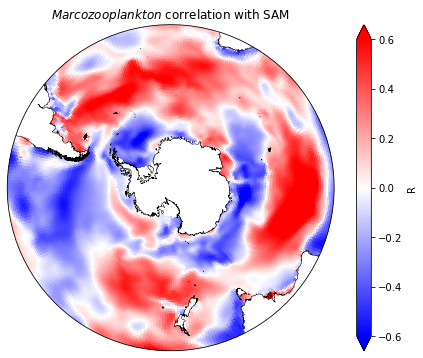

In [79]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\it Marcozooplankton}$ correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

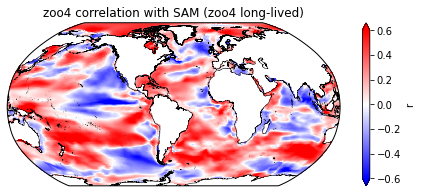

In [26]:
fig = plt.figure(figsize=(8,3))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 correlation with SAM (zoo4 long-lived)')
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo4C_zint)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [81]:
%%time
SAM_CHL_corr = xr.corr(ds.tot_CHL_surf, ts_sam, dim='time').squeeze()

CPU times: user 540 ms, sys: 1.45 s, total: 1.99 s
Wall time: 2.52 s


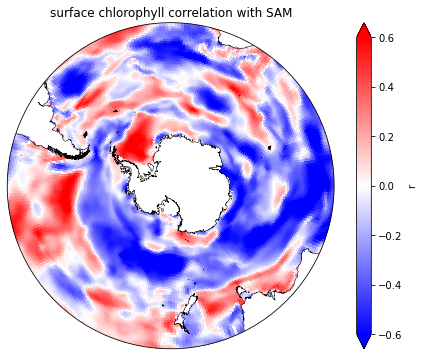

In [82]:
lon, lat, field = adjust_pop_grid(lons, lats, SAM_CHL_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('CESM surface chlorophyll correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [28]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.diatC_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

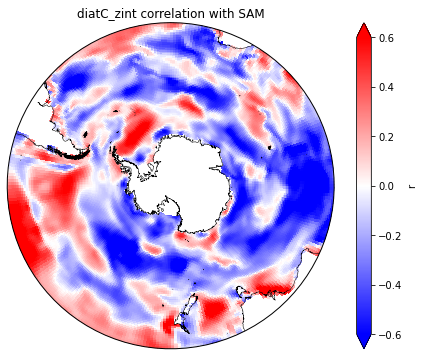

In [29]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [30]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.coccoC_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

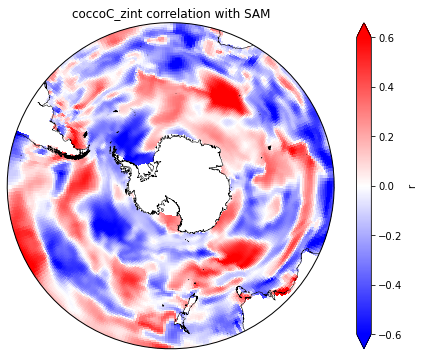

In [31]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('coccoC_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [32]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.phytoC_TOT_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

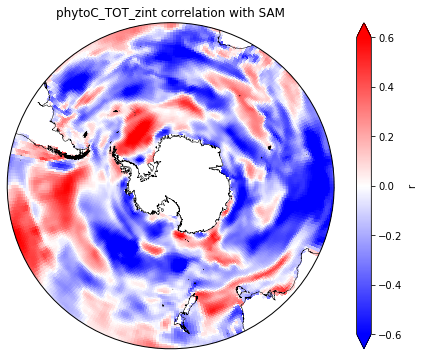

In [33]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('phytoC_TOT_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [34]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.spC_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

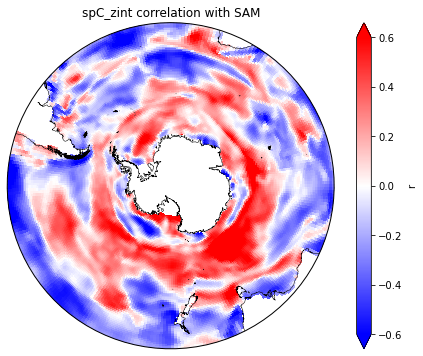

In [35]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('spC_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [36]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zooC_TOT_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

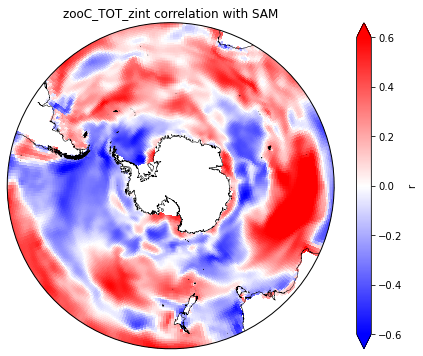

In [37]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC_TOT_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [38]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo1C_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

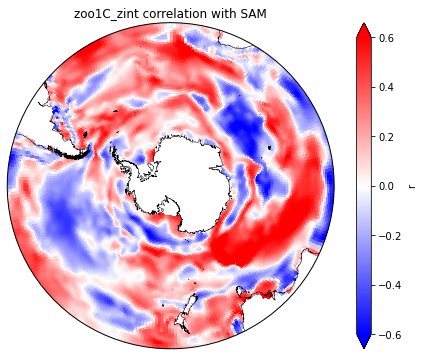

In [39]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1C_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [40]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo2C_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

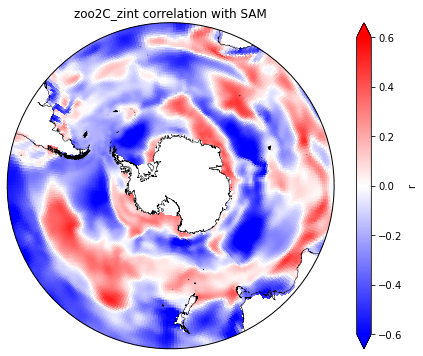

In [41]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo2C_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')

In [42]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo3C_zint)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

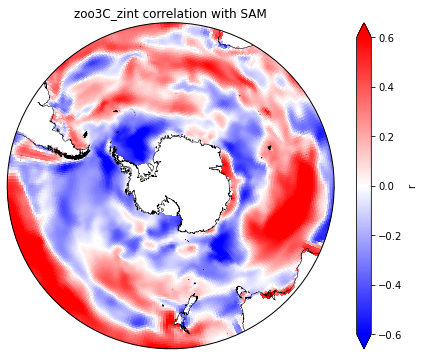

In [44]:
fig = plt.figure(figsize=(8,6))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3C_zint correlation with SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='r')